# my1stNN.ipynb (or MNIST digits classification with TensorFlow)

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week2/mnist_sample.png?raw=1" style="width:30%">

In [1]:
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week2_v2()  # change to the week you're working on
# note on week 2: select setup_week2_v2() if you've started the course after August 13, 2018,
# otherwise call setup_week2().

--2018-08-14 07:30:14--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2327 (2.3K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   2.27K  --.-KB/s    in 0s      

2018-08-14 07:30:14 (40.4 MB/s) - ‘setup_google_colab.py’ saved [2327/2327]

**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


### This task will be submitted for peer review, so make sure it contains all the necessary outputs!

In [33]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.10.0


# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [0]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


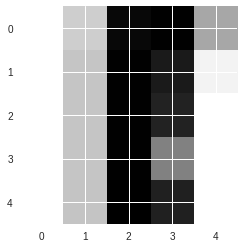

And the whole sample:


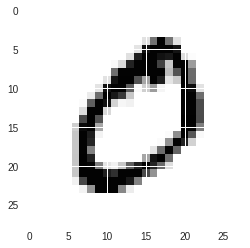

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [35]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [36]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [0]:
def get_one_hot(targets, nb_classes):
    """
    Get one-hot encoding from an array of indices
    
    Arguments:
    targets: array of indices
    nb_classes: number of classes
    
    Return:
    one-hot encoded matrix for the input array
    """
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [38]:
# get one hot encoding for y
y_train_oh = get_one_hot(y_train, 10)
y_val_oh = get_one_hot(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [0]:
# run this again if you remake your graph
s = reset_tf_session()

In [0]:
# reset tf graph
tf.reset_default_graph()

In [40]:
# Get parameters for x and y placeholder
(m, n_x) = X_train_flat.shape
n_y = y_train_oh.shape[1]
print(n_x, n_y, m)

784 10 50000


In [41]:
# Model parameters: W and b
W = tf.get_variable("W", [n_x, n_y], initializer=tf.contrib.layers.xavier_initializer(seed=1)) # tf.get_variable(...) with shape[0] = 784
b = tf.get_variable("b", [n_y, 1], initializer=tf.zeros_initializer()) # tf.get_variable(...)
print(W.shape)
print(b.shape)

(784, 10)
(10, 1)


In [42]:
# Placeholders for the input data
input_X = tf.placeholder(tf.float32, shape=[None, n_x]) # tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_y = tf.placeholder(tf.float32, shape=[None, n_y]) # tf.placeholder(...) for one-hot encoded true labels
print(input_X.shape)
print(input_y.shape)

(?, 784)
(?, 10)


In [73]:
# Compute predictions
logits = tf.add(tf.matmul(input_X, W), tf.transpose(b)) # logits for input_X, resulting shape should be [input_X.shape[0], 10]
print(input_X.shape[0])
print(logits.shape[0 ])

probas = tf.nn.softmax(logits) # apply tf.nn.softmax to logits
print(probas.shape)

classes = tf.argmax(probas, 1) # apply tf.argmax to find a class index with highest probability'
print(classes.shape)

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=logits))

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer(1e-4).minimize(loss)

?
?
(?, 10)
(?,)
Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


In [75]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDxPxd/wAFFP2PvAmoXmn%2BK/ipc2gs9UbTReHwpqj2l5eLfw6fJb2lwlsYb2SO7nigkW3eQxOxD7drY2j%2B2f8As6R%2BObL4c3XjHUbfVLy6sLNlu/Cmpw29le3sUctpY3dw9sIbG8lSWIraXDxzkzRjy8uoPiVz%2Bxn%2B1bH4C8N/s66Zqfw9HgXwn8W9N8V22tXOo3r6rqtnb%2BLrXWxbyQC1EVrLHAlxFvEswuJFiJ%2Bzqzbeh8cfsffGzXfGPi3wPoup%2BFv%2BEA8c/F7QfHuq61dalcrrOnvp8mlTyWEVqtu0Mwll0mLbcNcRmJLhh5TmNSwB6Fa/t1fsv3cGr3w8f30Nno2n3N7LqV54U1OC0vYLedLeZ7G4ktli1HbNJHHi1aYlpEAB3rns/hT8ZfAXxp0m91fwJc6njTdQNlqVnrfh690q8tJxGkuyW1voYZ48xyxupZAGVwQSDmvmbTf2IPj5a6t4mtbTwl8ONN8MazoOp22reBV8Za1feHfFN5cXcEsdw2mTwCPQGCJcEvZyTnzLkMRL5Q3egfs4/sm%2BOvDGmXP/AAu3xl4hhgsfFa6n4L8M6H8ZPEOpQaLbC3tla2mvpmtZtTheeGSUQXUbxRLKY1BQnIB0kX7eP7Kk0fiC6HxNlW18N6Jqur32oy%2BHdQS0urLTSRfzWVw1uItSFuRiQWjTFSQCMkZ5vx3/AMFL/wBmXwh4Vl8TaPd%2BJtceDxF4b0yXTdP8Dav9qeLW78WdnfwxNaB7m1crO0c8IeOZoTFEzyvGjeKaH/wSx%2BI%2BjfBrXPgl5eiXX9m/DfxR4c8C%2BK9W%2BK/ia/LzajZT2VtI%2Bkz5sdLUQzFZjALjJGY0j4A7z4//ALEPxs8d%2BOH%2BIfw%2B1Pwo9zp/hz4cxaTp2r6nc20dzfeG/FE2szxSyRW0phhlidIklVJGDliYsAbgD1V/25/2ZFtteu4/G%2BpzJ4b8Sf8ACPakLbwfqsrPq/nPCdOt1S1JvLsOhJggEkgQrIV2MrGpqn/BQX9lDSbTRp5PH%2Bq3U%2Bv2Wq3WmaXpfgnWLy/ZNMuIrfUFks4LR7iGW3lmRZIpI1kT5iVwjleFtv2OvjToXha08QaFfeFZvFegftCaz8R9G0y61O5j0%2B%2Bgvl1C3NnPcrbNJDILbUZSJFhlCyxJ8rCvMNI%2BEf7S3wX/AG5vCGqeD9N8Dav478U%2BA/iX4l1jSNT128tdItftmt%2BFwlvBdpZyzN5Srb5kNuvnFZfli8wbQD6jsf2yP2adU8Gaz8QtK%2BKVvd6PoNxpMGoXtpY3MoLapDaTaeYVWMtcrcJfWvlvCHVmkKZ3I6r6bXwN8Nv2Q7XwR%2B1Z8Ff2dvBXxLsNdsPh58M9Ff432dmnD3ugLu8PPKqki2klutRnuUjf52i06PGVQGvvmgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArzb4q/tdfs/fBPxlH4D%2BJPje4stR%2By2l1efZ9Bvru3023urh7a2nvbi3geGwilmjkRJLl41YxvgnY2PSa%2BQ/28f2Kv2o/2pNZ8Z6N4R%2BIWn/8I5rvhC0s/DFtqHxB1rSoNGvoXnkm8/TtPi8jU47ljApluZG8hVJWCXbscA9gh/br/ZUku9btpviqtrFoGn6hfXeoahot7bWVzb2EywXslndSwrDqAhldI3%2ByvKVd1U8sAdDwJ%2B2B%2Bz78R/EmneC/DXjC%2Bj1vVNTutPt9D1fwzqOnX0Vzb2kd5LHPb3dvHLbH7NLHMvnKgkSRShbIrwzQ/wBjX9rW8/ZXP7IXiDWvh5pWgaLpEn9ga1ZX99qF3qF9FqUN9YC5R7e3W2hjMRinKNO1xuDqIOYz1/jH4S/tp%2BNfiB4H%2BPWqaH8ME1/wZ4l1CS08HQeJtQWzGmXel/ZHLambAyTXAnHnAfY408s%2BVnK%2BawB2uh/t0/steJddsPDmh/EuW4utR0KfWotnh7UBFDpsM9zbzXk8pg8u1gSa0njaSZkUMEBP72Le3w9%2B3Z%2By74m8J6741sviFe21l4dsdPvdSj1fwrqdhctbX8jRWM0Ftc20c13Hcyq0UDQJIJpAUjLN8teO/s%2BfsI/tK/Bjw3q7xfFHwvY%2BKLj4J3fhXR/EWlxzSrY61Jq2rX0V6IZYgDAn263baWJ3RuuCAGbkrH/gnN%2B1HceNNR%2BImoa74div59G8Iz2dvrXxT1/xIw1jw7r39rQrLc6hbB/st3vlR/JSJbU7WjgmJY0AfUHw9/bC/Z2%2BJ%2Buy%2BF/Cnj%2BRdTttLvdQvdN1fRL3Tbizgs5Yorrz47uGJoHia4ty8UgWRVnicrskRj2nw98e%2BFvip4C0T4m%2BBr%2BS70XxFpNvqWkXU1nLbtNazxrLE5imVJIyUZTtdVYZwQDxXxx%2B3H8PfjP8Ybb4c/D3xh4x8IaH8UvFXjTUNFj8PeD724unh8D6lZNaa0vnSpDLMYoUS7N2YYIxPDbRBdxQyfbOnadYaRp8Gk6XZx29rawrDbW8KBUijUAKqgcAAAAD2oAmooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDyj41/tB%2BP/g7440e2m%2BDkF54S1DXtD0WbxFL4mWK7lvNTvxZotpYrDIbhYC8cs7SSwbYi7IJfLYVR%2BL/AO054/8Ag78SdP0LXPgnA/hjVtaOkaTrh8UqL6/uxpc%2BoNJDYpA4Nqgt5InkeZJVaOR/JaNVkd3xF/Z8%2BMniz9o3T/jnoPxf8KpYaLpSWnh7w74k8CXWoDSZmMgu7yCWLVLdBcTxusPmNEzRxoUQgSzCSCX9nD4y3v7Rd/8AHLV/jR4YvLW40qLS9K0%2B68AzyXehWZgQXSWU7akYInnuFaZ5HtpGZRDE/mLAlAFz9jX9pu//AGrPhhD8Tbmz8DWsd1ZWU62Xg34gnXpLJ54BM1veZs7b7NOgdAY/nJyemBn0vxVrN3oenpd2iRszTBCJFJGME9iPSvPPgJ%2Bz34x%2BGfjrW/if8SfiRpXiHXNX8NaPoCNoHhP%2BxrSKx057ySEtB9on3zM99NuYMkYVY1SKMBtyfGr48nwL8dPAfwL%2Bz

# Adding more layers

Let's add a couple of hidden layers and see how that improves our validation accuracy!

Rememeber that we need non-linearities for hidden layers (e.g. `tf.sigmoid`)!

Now add 1 or more hidden layers to the code above and restart training.
You're aiming for ~0.98 validation accuracy here.